# Part 5: Model Evaluation

---

## Notebook Summary

This notebook will take our final production model and evaluate its effectiveness against multiple metrics. The goal here is to see how well our model can answer the problem statement of classifying neurodiverse people into either the ADHD or autism categories based on their own personal testimonies of everyday lived experiences. The metric established in the problem statement was to exceed the null baseline accuracy score by forty percentage points. Included in this notebook, the reader will find:

* Production Model Evaluation
* Organizational Recommendations

---

## Production Model Evaluation

We will be evaluating the final production model of the logistic regression below. First, we will read in the data one more time and then fit the production model again.

In [1]:
# import requisite libraries
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category = UserWarning)

In [2]:
# reads in dataset
sr_posts = pd.read_csv('./data_files/sr_posts_cleaned.csv')

sr_posts

,title,selftext,subreddit,post_word_count,post_length,selftext_lemma,sentiment
0,Megathread: US Medication Shortage,as many of you are aware by now the current u ...,0,319,2033,a many of you are aware by now the current u s...,-0.9567
1,Did you do something you're proud of? Somethin...,what success have you had this week did you ac...,0,52,288,what success have you had this week did you ac...,0.9633
2,The Vyvanse poops have taken over my mornings..,i now wake up at least 1 5 hours early to ensu...,0,85,379,i now wake up at least 1 5 hour early to ensur...,0.6124
3,Why does someone forcing you to push through e...,i can t even explain how it hurts but it s so ...,0,62,304,i can t even explain how it hurt but it s so m...,-0.8755
4,Just had an epiphany- isn’t it crazy how relig...,so my mom can believe in all her saints god je...,0,175,897,so my mom can believe in all her saint god jes...,-0.9856
...,...,...,...,...,...,...,...
4579,Scared of old people,anyone else scared of old people when i talk t...,1,77,398,anyone else scared of old people when i talk t...,-0.7933
4580,Recommendations for blocking out noise for sleep,i have a really hard time sleeping due to even...,1,116,588,i have a really hard time sleeping due to even...,-0.6284
4581,Mom Refuses Access to Diagnosis Report,i 17f was diagnosed with autism and adhd aroun...,1,83,403,i 17f wa diagnosed with autism and adhd around...,-0.4019
4582,Do you feel uncomfortable with everyday sounds?,i m talking about inevitable sounds as birds d...,1,204,1067,i m talking about inevitable sound a bird dog ...,0.3574


In [3]:
sr_posts.dtypes

title               object
selftext            object
subreddit            int64
post_word_count      int64
post_length          int64
selftext_lemma      object
sentiment          float64
dtype: object

In [4]:
# check for nulls
sr_posts.isnull().sum()

title               0
selftext            7
subreddit           0
post_word_count     0
post_length         0
selftext_lemma     10
sentiment           0
dtype: int64

In [5]:
# drop all null values
sr_posts.dropna(inplace = True)

In [6]:
# check for nulls
sr_posts.isnull().sum()

title              0
selftext           0
subreddit          0
post_word_count    0
post_length        0
selftext_lemma     0
sentiment          0
dtype: int64

In [7]:
# displays proportion of posts belonging to each subreddit
sr_posts['subreddit'].value_counts(normalize = True)

1    0.500219
0    0.499781
Name: subreddit, dtype: float64

In [8]:
# declares features and target variable, then train/test splits dataset
X = sr_posts['selftext_lemma']
y = sr_posts['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [9]:
# builds a list of stop words including English and adding subreddit specific words
new_stop_words = stopwords.words('english')
incl_stop_words = ['don', 've', 'autism', 'autistic', 'adhd', 'medication', 'meds']
for word in incl_stop_words:
    new_stop_words.append(word)

In [10]:
# creates a pipeline for the CountVectorizer and Logistic Regression
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = new_stop_words)),
    ('lr', LogisticRegression(max_iter = 5000))
])

In [11]:
# creates the pipe params for pipe
pipe_params = {
    'cvec__max_features': [4000, 5000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [1.0, 0.8],
    'lr__penalty': ['l2', None],
    'lr__C': [0.1, 1, 10]
}

In [12]:
# runs a grid search over pipe for the given params
gs = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)

# fits the grid search over our train data and prints best score and best params
gs.fit(X_train, y_train)
print(gs.best_score_) 
gs.best_params_

0.8206997084548104


{'cvec__max_df': 1.0,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [13]:
# print training and test scores
print(f'Logistic Regression Lemmatized Training Score: {gs.score(X_train, y_train)}')
print(f'Logistic Regression Lemmatized Test Score: {gs.score(X_test, y_test)}')

Logistic Regression Lemmatized Training Score: 0.9565597667638484
Logistic Regression Lemmatized Test Score: 0.8199300699300699


We have already seen that this logistic regression model on our lemmatized, count vectorized words has an accuracy score of approximately 0.82 based on the test dataset. We know that the accuracy score is not the only metric to assess how well a model is performing. We will first make a confusion matrix for our production model to visualize how well our model is performing. Then we will look at the model's specificity, recall and precision to get a sense of how well it is performing on other metrics.

In [14]:
# creates predictions based on our model
preds = gs.predict(X_test)

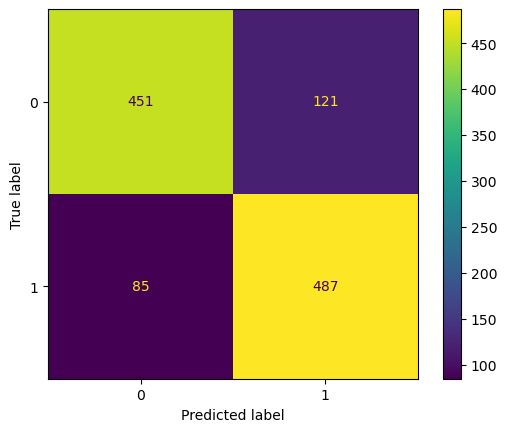

In [17]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

Upon first glance of the confusion matrix, we can see that it appears that the model is better at predicting autistic text posts than it is at predicting ADHD text posts, just given the larger number of true positives in comparison to true negatives and the facts that the classes are split almost exactly evenly. This means that we can anticipate seeing a better recall rate than specificity rate since there are less false negatives than there are false positives.

Let's investigate these other metrics.

In [18]:
# creates confusion matrix of 
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [19]:
# calculates the model specificity
spec = tn / (tn + fp)
spec

0.7884615384615384

In [20]:
# calculates the model recall
recall = recall_score(y_test, preds)
recall

0.8513986013986014

As we suggested it appears that our production model is more sensitive than it is specific. This would indicate that our model is better at picking up a higher proportion of the true positives to the total actual positives, approximately 0.85 as compared to its ability to detect the proportion of true negatives out of the total actual negatives, approximately 0.79.

We can now compare the slightly higher recall score to the precision score and then our f1 score to see if there is a large difference in comparison to our original accuracy test score.

In [21]:
# calculates the model precision
precision = precision_score(y_test, preds)
precision

0.8009868421052632

In [23]:
# calculates the model's f1 score
f1_score(y_test, preds)

0.8254237288135593

Looking at the precision score, we can see that it is approximately 0.80, meaning that approximately 80% of the predicted positives are actually positive. In the case of our model, this means that we are correct in predicting autism only about 80% of the time that we predict a text is coming from the autism subreddit. The other 20% of the time we are finding that these are false positives, indicating that we are labeling ADHD posts erroneously.

Lastly, with the f1 score of approximately 0.83 we see the harmonic mean between the precision and recall scores. This f1 score performs only slighlty better than our final test score of approximately 0.82. Our f1 score might make more sense for us to use if had we more unbalanced classes, which skewed our accuracy score, but in this case, given the very close nature of the two classes, we argue that the accuracy score is sufficient to evaluate this model's effectiveness.

We will now leave with some final conclusions for our disability advocacy organization for neurodiverse people.

---

## Organizational Recommendations

After multiple model iterations, we have concluded that using lemmatized text posts from our two subreddits with common English stop words and a few additional, specific stop words were likely the best performing features for our model. We saw that this model had approximately a 0.82 accuracy score about 32 percentage points above the null baseline accuracy score. Our goal was to develop a model with approximately 90% accuracy, so our production model here unfortunately faalls short and misclassifies text posts about 18% of the time.

We shall discuss the findings and recommendations below:

---

**Finding 1:** The final logistic regression production model after multiple model iterations only achieved about 82% accuracy, which failed to meet our target of a model which could predict with 90% accuracy.

**Recommendation 1:** The disability advocacy organization may choose to invest in refining this model further, either by gaining access to or purchasing more social media data from other websites such as Twitter, Facebook, or the like where there are similar affinity communities of neurodiverse people discussing their own experience. Collecting more data from different social media platforms may yield slightly better results in our model, as this may pull in a more diverse collection of people's experiences and perhaps wider demographics.

---

**Finding 2:** The final logistic regression production model is more sensitive than it is precise. This means that out of all the actual posts on the autism subreddit, the model predicted that they were autism posts about 85% of the time, which slightly exceeded the model's accuracy of 82%. However, the model was less precise so out of all its predictions of autism, it was only correct about 80% of the time. In this case, false positives were more common than false negatives.

**Recommendation 2:** Should the disability advocacy organization use this model to refer neurodiverse novices to social support groups or services, the organization should take extra care in building in another layer of support to screen for people with ADHD who were erroneously misclassified as having autism. While this model can be used as an initial screening tool for people seeking help and seeking to put a name to their experience, an expert in leading some of these social groups may be present during an initial meeting to guide new attendees in whether their experience most likely fits that of ADHD or autism. While this may appear to defeat the purpose of having the model in the first place and avoiding medical evaluation, we would argue that it still gets predictions correct approximately 82% of the time, so a lot of time and money can be saved in evaluating each individual and instead focus on the organization autism social support groups and looking for referred members who may be experiencing more signs of living with ADHD than with autism.

---

**Finding 3:** In our exploratory data analysis, corroborated by outside research, we see extremely high overlap in the bag of words used most frequently to describe the lived experiences of people with ADHD and autism, both in common social language, but also in themes of specific topics which appear similar across the neurodiverse spectrum of experiences.

**Recommendation 3:** The disability advocacy organization may do well to begin offering a peer social support group for all novice neurodiverse people regardless of their suspicions of belonging to either ADHD or autism communities. While their is still a definite need for affinity groups and support services tailored to the needs of specific disabilities, for the novice exploring their disability identity and consciousness, it may be a sufficient first step to have the option of a mixed group of neurodiverse with whom to engage and share experiences.